# Contradictory, My Dear Watson - NLP Project
In this project, we will build a Natural Language Processing (NLP) model which will classify pairs of sentences as 'entailment' , 'contradiction', or 'neutral'. This is a classic problem in NLP called Natural Language Inferencing, which involves the comparison of **premise** and **hypothesis** statements to determine a relationship. Such classification would be useful for programs which navigate human conversation (chatbots, AI writing tools, etc.) in order to better parse the flow of conversation and navigate dialog trees. 

The datset for this project is provided on Kaggle https://www.kaggle.com/competitions/contradictory-my-dear-watson/data. The model built here will be submitted as an entry for this competition. 

## Data Exploration
The training data provided consists of several thousand sentence pairs across a number of unique languages. Let's import the data and get a sense of the variables provided.

In [1]:
# import pertinent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

import os

2022-07-04 21:14:01.433773: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-04 21:14:01.433880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load the training data into a pandas data frame
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

# print first five rows of the data
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Our sentences for comparison can be found in the 'premise' and 'hypothesis' columns. These statements can range across languages specified in the 'lang_abv' and 'language' columns. The 'label' column designates the human label describing the relationship between these variables; 0 = 'entailment', 1 = 'neutral', 2 = 'contradiction'. Let's get an example of a pair in english.

In [3]:
train.premise[0]

'and these comments were considered in formulating the interim rules.'

In [4]:
train.hypothesis[0]

'The rules developed in the interim were put together with these comments in mind.'

These sentences entail each other, because the truth of one requires the truth of the other. This is pretty intuitive to English-speaking human minds. Let's look at an example of a contradiction. 

In [5]:
train.premise[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [6]:
train.hypothesis[1]

'Practice groups are not permitted to work on these issues.'

These statements are contradictory. If practice groups are not permitted to work on these issues, then they cannot be the issues that the law firms wrestle with in their practice groups.

Let's look at the distribution of languages available to our training set.

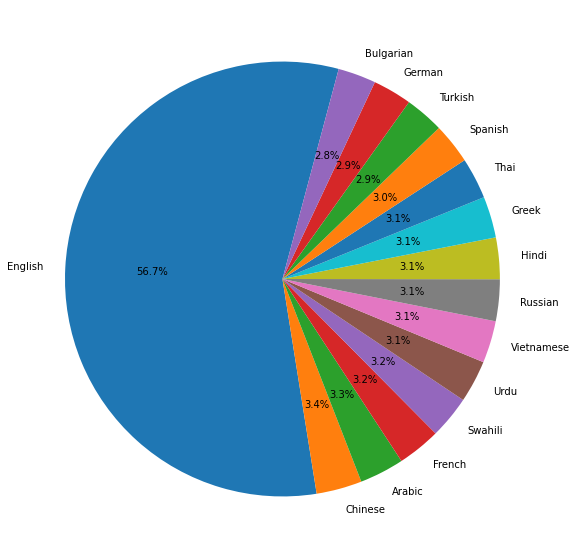

In [7]:
# Group data drame by language and count the number of entries in each language
language_counts = train.language.value_counts()

# Plot the percent of total entries for each language
%matplotlib inline
plt.figure(figsize = (10,10))
plt.pie(language_counts, autopct = '%1.1f%%', labels = language_counts.index, startangle=75)
plt.show()


## Data Preparation
We have a good spread of languages here! It may seem daunting, but luckily we do not need to re-invent the wheel or learn 10+ new languages. Luckily, the folks over at huggingface have already put together a nice package for the analysis of multilingual data sets. To start with, we will use their BERT model: https://github.com/google-research/bert/blob/master/multilingual.md

The data needs to be tokenized - the words transformed into arrays of numbers. 

In [8]:
# Download BERT model
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# function to apply tokenizer to sentence
def encode_sentence(sentence):
    tokens = list(tokenizer.tokenize(sentence))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

# Test function on example sentence
encode_sentence('Encode this sentence')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

[10243, 54261, 10531, 49219, 102]

In [9]:
# set up tensor processing units
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

2022-07-04 21:14:09.776650: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-04 21:14:09.779631: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-04 21:14:09.779675: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-04 21:14:09.779701: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9260187615e7): /proc/driver/nvidia/version does not exist
2022-07-04 21:14:09.782813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

The BERT model takes three inputs: input word IDs, input masks, and input type IDs. We need to add a [CLS] token to designate beginning of inputs, and add [SEP] tokens to designate the separation between premises and hypotheses. Inputs need to be the same size, so we will have to add some padding. 

Let's encode the training set.

In [10]:
# encodes training data using the tokenizer
def bert_encode(hypotheses, premises, tokenizer):
    # save number of samples
    n = len(hypotheses)
    
    hyp = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    pre = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
    
    # generate cls tokens
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * hyp.shape[0]
    
    # generate input word ids
    input_word_ids = tf.concat([cls, hyp, pre], axis=-1)
    
    # generate input mask
    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=[input_word_ids.shape[0], 200])
    
    type_cls = tf.zeros_like(cls)
    type_hyp = tf.zeros_like(hyp)
    type_pre = tf.ones_like(pre)
    
    input_type_ids = tf.concat([type_cls, type_hyp, type_pre], axis=-1).to_tensor(shape=[input_word_ids.shape[0], 200])
    
    # format encoded inputs and return
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(shape=[input_word_ids.shape[0], 200]),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }
    
    return inputs

In [11]:
# encode training set
train_encoded = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

## Model Building & Training
Let's incorporate the BERT transformer into a Keras Functional Model (https://www.tensorflow.org/guide/keras/functional).

In [12]:
# builds model by incorporating BERT transformer into Keras Functional Model
max_len = 200
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_type_ids')
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
# build model
with strategy.scope():
    model = build_model()
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [14]:
# fit the model to our training data
model.fit(train_encoded, train.label.values, epochs=2, verbose=1, batch_size=64, validation_split=0.2)

Epoch 1/2
152/152 [==============================] - 141s 464ms/step - loss: 1.0839 - accuracy: 0.4318 - val_loss: 0.8523 - val_accuracy: 0.6217
Epoch 2/2
152/152 [==============================] - 15s 102ms/step - loss: 0.7900 - accuracy: 0.6563 - val_loss: 0.7991 - val_accuracy: 0.6522


In [15]:
# test the fitted model with the test data
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_encoded = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [16]:
# examine test head
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


## Generating and Submitting Predictions
Now that we have our fit model, we can use the encoded test data to generate predictions. These predictions will be compared to the true results to give us our Kaggle ranking. Our trained model received an accuracy score of ~64% on the validation data; This is a good place to start, but a look to the leaderboards shows that many models are scoring over 98%! How can we improve our tensorflow model from here?

In [17]:
# generating predictions
predictions = [np.argmax(i) for i in model.predict(test_encoded)]

# convert test data to dataframe
submission = test.id.copy().to_frame()

# add our predictions
submission['prediction'] = predictions

# check submission frame
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0


In [18]:
# save predictions to csv for kaggle submission
submission.to_csv('submission.csv', index = False)